# Lab 3: Bayes Classifier and Boosting

## Jupyter notebooks

In this lab, you can use Jupyter <https://jupyter.org/> to get a nice layout of your code and plots in one document. However, you may also use Python as usual, without Jupyter.

If you have Python and pip, you can install Jupyter with `sudo pip install jupyter`. Otherwise you can follow the instruction on <http://jupyter.readthedocs.org/en/latest/install.html>.

And that is everything you need! Now use a terminal to go into the folder with the provided lab files. Then run `jupyter notebook` to start a session in that folder. Click `lab3.ipynb` in the browser window that appeared to start this very notebook. You should click on the cells in order and either press `ctrl+enter` or `run cell` in the toolbar above to evaluate all the expressions.

Be sure to put `%matplotlib inline` at the top of every code cell where you call plotting functions to get the resulting plots inside the document.

## Import the libraries

In Jupyter, select the cell below and press `ctrl + enter` to import the needed libraries.
Check out `labfuns.py` if you are interested in the details.

In [2]:
import numpy as np
from scipy import misc
from importlib import reload
import random
from sklearn.datasets import make_blobs, make_classification
from labfuns import *  # noqa: F403


## Bayes classifier functions to implement

The lab descriptions state what each function should do.

### Assignment 1 and 2 (non boosted)

In [24]:
# NOTE: you do not need to handle the W argument for this part!
# in: labels - N vector of class labels
# out: prior - C x 1 vector of class priors
def computePrior(labels, W=None):
    Npts = labels.shape[0]
    if W is None:
        W = np.ones((Npts,1))/Npts
    else:
        assert(W.shape[0] == Npts)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    prior = [0] * Nclasses

    for k in range(Nclasses):
        prior[k] = np.sum(labels==classes[k]) / Npts

    return prior

# NOTE: you do not need to handle the W argument for this part!
# in:      X - N x d matrix of N data points
#     labels - N vector of class labels
# out:    mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
def mlParams(X, labels, W=None):
    assert(X.shape[0]==labels.shape[0])
    Npts,Ndims = np.shape(X)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    if W is None:
        W = np.ones((Npts,1))/float(Npts)

    mu = np.zeros((Nclasses,Ndims))
    sigma = np.zeros((Nclasses,Ndims,Ndims))

    for k in range(Nclasses):

        mu[k] = np.mean(X[labels==classes[k]], axis=0) # column-wise mean

        for m in range(Ndims):
            cov_sum = 0
            for j in range(Npts):
                if labels[j] == classes[k]:
                    cov_sum += (X[j][m] - mu[k][m])**2
                
            sigma[k, m, m] = cov_sum / np.sum(labels==classes[k]) # column-wise covariance


    return mu, sigma

In [14]:
# in:      X - N x d matrix of M data points
#      prior - C x 1 matrix of class priors
#         mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
# out:     h - N vector of class predictions for test points
def classifyBayes(X, prior, mu, sigma):

    Npts = X.shape[0]
    Nclasses, Ndims = np.shape(mu)
    logProb = np.zeros((Nclasses, Npts))

    for x in range(Npts):
        for k in range(Nclasses):
            logprior = np.log(prior[k])
            detsigma = 0.5 * np.log(np.linalg.det(sigma[k])) 
            dotprod = 0.5 * np.linalg.multi_dot([X[x] - mu[k], np.diag(1/np.diag(sigma[k])), (X[x] - mu[k]).T])
            
            logProb[k][x] = logprior - detsigma - dotprod

    h = np.argmax(logProb, axis=0)
    return h

In [21]:
X, y = make_blobs()
mu, sigma = mlParams(X, y)
prior = computePrior(y)
h = classifyBayes(X, prior, mu, sigma)
sigma

(3, 2)


array([[[1.15788988, 0.        ],
        [0.        , 0.95396959]],

       [[0.83177058, 0.        ],
        [0.        , 1.13003086]],

       [[1.15394872, 0.        ],
        [0.        , 1.17881907]]])

The implemented functions can now be summarized into the `BayesClassifier` class, which we will use later to test the classifier, no need to add anything else here:

In [25]:
# NOTE: no need to touch this
class BayesClassifier(object):
    def __init__(self):
        self.trained = False

    def trainClassifier(self, X, labels, W=None):
        rtn = BayesClassifier()
        rtn.prior = computePrior(labels, W)
        rtn.mu, rtn.sigma = mlParams(X, labels, W)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBayes(X, self.prior, self.mu, self.sigma)

## Test the Maximum Likelihood estimates

Call `genBlobs` and `plotGaussian` to verify your estimates.

(5, 2)
[[-0.47868754  8.84384589]
 [-0.23392565  5.93738788]
 [ 6.10385428 -3.95482318]
 [-1.45259819 -7.84241717]
 [ 3.8909211   9.55158196]]
[[[0.54250961 0.        ]
  [0.         0.90812931]]

 [[0.943285   0.        ]
  [0.         0.81811618]]

 [[0.77890865 0.        ]
  [0.         0.81171647]]

 [[1.02690522 0.        ]
  [0.         1.44458373]]

 [[0.96848782 0.        ]
  [0.         0.96956849]]]


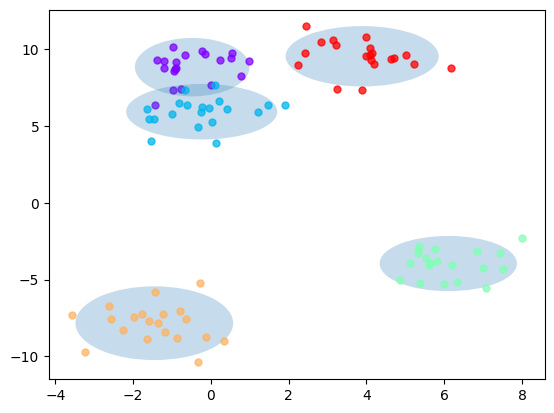

In [22]:
%matplotlib inline

X, labels = make_blobs(centers=5)
mu, sigma = mlParams(X,labels)
print(mu)
print(sigma)
plotGaussian(X,labels,mu,sigma)  # noqa: F405


Call the `testClassifier` and `plotBoundary` functions for this part.

In [26]:
testClassifier(BayesClassifier(), dataset='iris', split=0.7)  # noqa: F405


Trial: 0 Accuracy 84.4
Trial: 10 Accuracy 95.6
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 86.7
Trial: 40 Accuracy 88.9
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 86.7
Trial: 70 Accuracy 91.1
Trial: 80 Accuracy 86.7
Trial: 90 Accuracy 91.1
Final mean classification accuracy  89 with standard deviation 4.16


In [27]:
testClassifier(BayesClassifier(), dataset='vowel', split=0.7)  # noqa: F405


Trial: 0 Accuracy 61
Trial: 10 Accuracy 66.2
Trial: 20 Accuracy 74
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 64.3
Trial: 60 Accuracy 66.9
Trial: 70 Accuracy 63.6
Trial: 80 Accuracy 62.3
Trial: 90 Accuracy 70.8
Final mean classification accuracy  64.7 with standard deviation 4.03


/Users/lelle/KTH4/ml/bayesboost/labfuns.py:256: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xTr[trClIdx,0],xTr[trClIdx,1],marker='o',c=color,s=40,alpha=0.5, label="Class "+str(c)+" Train")
/Users/lelle/KTH4/ml/bayesboost/labfuns.py:257: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xTe[teClIdx,0],xTe[teClIdx,1],marker='*',c=color,s=50,alpha=0.8, label="Class "+str(c)+" Test")


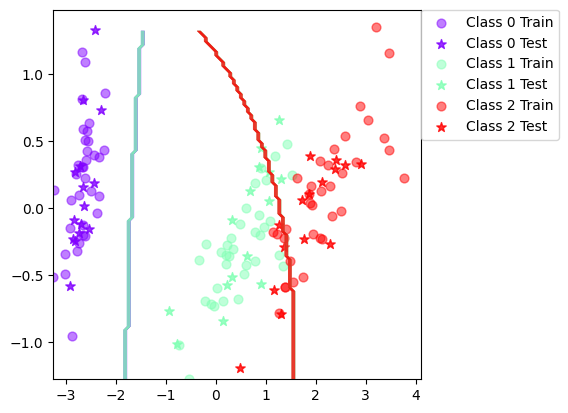

In [28]:
%matplotlib inline
plotBoundary(BayesClassifier(), dataset='iris',split=0.7)  # noqa: F405


## Boosting functions to implement

The lab descriptions state what each function should do.

### Assignment 4 and 5 (with W implementation)

In [7]:
# NOTE: you do not need to handle the W argument for this part!
# in: labels - N vector of class labels
# out: prior - C x 1 vector of class priors
def computePriorW(labels, W=None):
    Npts = labels.shape[0]
    if W is None:
        W = np.ones(Npts)/Npts
    else:
        assert(W.shape[0] == Npts)
        
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    # compute the values of prior for each class with W into account
    prior = [0] * Nclasses
    
    for k in range(Nclasses):
        prior[k] = np.sum(W[labels==classes[k]]) / np.sum(W)
    return prior

# NOTE: you do not need to handle the W argument for this part!
# in:      X - N x d matrix of N data points
#     labels - N vector of class labels
# out:    mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
def mlParamsW(X, labels, W=None):
    assert(X.shape[0]==labels.shape[0])
    Npts,Ndims = np.shape(X)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    if W is None:
        W = np.ones(Npts)/float(Npts)

    mu = np.zeros((Nclasses,Ndims))
    sigma = np.zeros((Nclasses,Ndims,Ndims))

    for k in range(Nclasses):
        W_class = W[labels == classes[k]][:, None] # (N, 1) column vector

        # column-wise mean with W into account
        mu[k] = np.sum(X[labels==classes[k]] * W_class, axis=0) / np.sum(W[labels==classes[k]])

        # covariance with W into account
        for m in range(Ndims):
            cov_sum = 0
            for j in range(Npts):
                if labels[j] == classes[k]:
                    cov_sum += W[j]*(X[j][m] - mu[k][m])**2
                
            sigma[k, m, m] = cov_sum / np.sum(W[labels==classes[k]]) # column-wise covariance


    return mu, sigma

In [8]:
# NOTE: no need to touch this
class BayesClassifierW(object):
    def __init__(self):
        self.trained = False

    def trainClassifier(self, X, labels, W=None):
        rtn = BayesClassifierW()
        rtn.prior = computePriorW(labels, W)
        rtn.mu, rtn.sigma = mlParamsW(X, labels, W)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBayes(X, self.prior, self.mu, self.sigma)

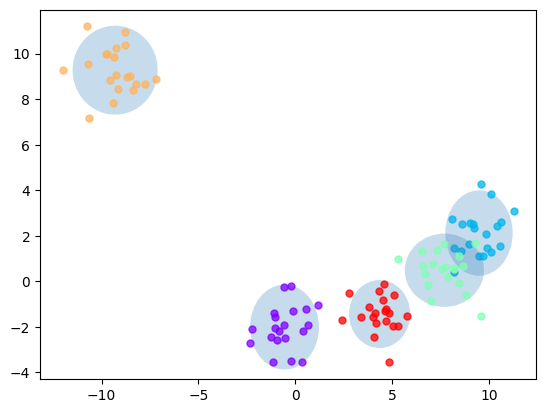

In [9]:
%matplotlib inline

X, labels = make_blobs(centers=5)
mu, sigma = mlParamsW(X,labels)
prior = computePriorW(labels)
plotGaussian(X,labels,mu,sigma)  # noqa: F405

In [10]:
# in: base_classifier - a classifier of the type that we will boost, e.g. BayesClassifier
#                   X - N x d matrix of N data points
#              labels - N vector of class labels
#                   T - number of boosting iterations
# out:    classifiers - (maximum) length T Python list of trained classifiers
#              alphas - (maximum) length T Python list of vote weights
def trainBoost(base_classifier, X, labels, T=10):
    # these will come in handy later on
    Npts,Ndims = np.shape(X)

    classifiers = [] # append new classifiers to this list
    alphas = [] # append the vote weight of the classifiers to this list

    # The weights for the first iteration (normailized)
    wCur = np.ones(Npts)/float(Npts)

    for i_iter in range(0, T):
        # a new classifier can be trained like this, given the current weights
        classifiers.append(base_classifier.trainClassifier(X, labels, wCur))

        # do classification for each point
        vote = classifiers[-1].classify(X)

        # Step 2: Compute the error
        epsilon = 0
        for i in range(len(vote)):
            if vote[i] != labels[i]:
                epsilon += wCur[i]

        # Step 3: Compute the vote weight
        alpha = 0.5 * (np.log(1 - epsilon) - np.log(epsilon))
        alphas.append(alpha)

        # Step 4: Update the weights
        for i in range(len(wCur)):
            if vote[i] == labels[i]:
                wCur[i] = wCur[i] * np.exp(-alpha)
            else:
                wCur[i] = wCur[i] * np.exp(alpha)
        
        # Step 5: Normalize the weights
        wCur = wCur / np.sum(wCur)
    
    return classifiers, alphas

# in:       X - N x d matrix of N data points
# classifiers - (maximum) length T Python list of trained classifiers as above
#      alphas - (maximum) length T Python list of vote weights
#    Nclasses - the number of different classes
# out:  yPred - N vector of class predictions for test points
def classifyBoost(X, classifiers, alphas, Nclasses):
    Npts = X.shape[0]
    Ncomps = len(classifiers)

    # if we only have one classifier, we may just classify directly
    if Ncomps == 1:
        return classifiers[0].classify(X)
    else:
        votes = np.zeros((Npts,Nclasses))

        for t in range(Ncomps):
            hypothesis = classifiers[t].classify(X)

            for x_i in range(Npts):
                votes[x_i][hypothesis[x_i]] += alphas[t]

        # one way to compute yPred after accumulating the votes
        return np.argmax(votes,axis=1)

In [15]:
X, y = make_blobs()
classifiers, alphas = trainBoost(BayesClassifierW(), X, labels, T=10)  # noqa: F405

The implemented functions can now be summarized another classifer, the `BoostClassifier` class. This class enables boosting different types of classifiers by initializing it with the `base_classifier` argument. No need to add anything here.

In [12]:
# NOTE: no need to touch this
class BoostClassifier(object):
    def __init__(self, base_classifier, T=10):
        self.base_classifier = base_classifier
        self.T = T
        self.trained = False

    def trainClassifier(self, X, labels):
        rtn = BoostClassifier(self.base_classifier, self.T)
        rtn.nbr_classes = np.size(np.unique(labels))
        rtn.classifiers, rtn.alphas = trainBoost(self.base_classifier, X, labels, self.T)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBoost(X, self.classifiers, self.alphas, self.nbr_classes)

## Run some experiments

Call the `testClassifier` and `plotBoundary` functions for this part.

In [16]:
testClassifier(BoostClassifier(BayesClassifierW(), T=10), dataset='iris',split=0.7)  # noqa: F405

Trial: 0 Accuracy 95.6


/var/folders/f9/rnwg8ghd29b6v6mj5_kz5fb80000gn/T/ipykernel_61520/2283641823.py:31: RuntimeWarning: divide by zero encountered in log
  alpha = 0.5 * (np.log(1 - epsilon) - np.log(epsilon))
/var/folders/f9/rnwg8ghd29b6v6mj5_kz5fb80000gn/T/ipykernel_61520/2283641823.py:42: RuntimeWarning: invalid value encountered in divide
  wCur = wCur / np.sum(wCur)
/Users/lelle/KTH4/ml/.venv/lib/python3.11/site-packages/numpy/linalg/_linalg.py:2432: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Trial: 10 Accuracy 100
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 97.8
Trial: 50 Accuracy 93.3
Trial: 60 Accuracy 93.3
Trial: 70 Accuracy 97.8
Trial: 80 Accuracy 95.6
Trial: 90 Accuracy 93.3
Final mean classification accuracy  94.1 with standard deviation 6.72


In [124]:
testClassifier(BoostClassifier(BayesClassifierW(), T=10), dataset='vowel',split=0.7)

Trial: 0 Accuracy 76.6
Trial: 10 Accuracy 86.4
Trial: 20 Accuracy 83.1
Trial: 30 Accuracy 80.5
Trial: 40 Accuracy 72.7
Trial: 50 Accuracy 76
Trial: 60 Accuracy 81.8
Trial: 70 Accuracy 82.5
Trial: 80 Accuracy 79.9
Trial: 90 Accuracy 83.1
Final mean classification accuracy  80.2 with standard deviation 3.52


/Users/lelle/KTH4/ml/bayesboost/labfuns.py:256: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xTr[trClIdx,0],xTr[trClIdx,1],marker='o',c=color,s=40,alpha=0.5, label="Class "+str(c)+" Train")
/Users/lelle/KTH4/ml/bayesboost/labfuns.py:257: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xTe[teClIdx,0],xTe[teClIdx,1],marker='*',c=color,s=50,alpha=0.8, label="Class "+str(c)+" Test")


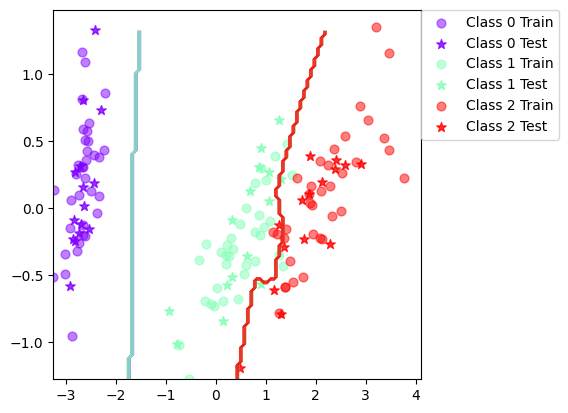

In [126]:
%matplotlib inline
plotBoundary(BoostClassifier(BayesClassifierW()), dataset='iris',split=0.7)

Now repeat the steps with a decision tree classifier.

In [3]:
testClassifier(DecisionTreeClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 91.1
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 88.9
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 88.9
Final mean classification accuracy  92.4 with standard deviation 3.67


In [17]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 95.6
Trial: 30 Accuracy 93.3
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 95.6
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 93.3
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 93.3
Final mean classification accuracy  94.6 with standard deviation 3.65


In [18]:
testClassifier(DecisionTreeClassifier(), dataset='vowel',split=0.7)

Trial: 0 Accuracy 63.6
Trial: 10 Accuracy 68.8
Trial: 20 Accuracy 63.6
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 63
Trial: 60 Accuracy 59.7
Trial: 70 Accuracy 68.8
Trial: 80 Accuracy 59.7
Trial: 90 Accuracy 68.2
Final mean classification accuracy  64.1 with standard deviation 4.02


In [19]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='vowel',split=0.7)

Trial: 0 Accuracy 85.1
Trial: 10 Accuracy 89.6
Trial: 20 Accuracy 87
Trial: 30 Accuracy 92.2
Trial: 40 Accuracy 84.4
Trial: 50 Accuracy 80.5
Trial: 60 Accuracy 86.4
Trial: 70 Accuracy 85.7
Trial: 80 Accuracy 89
Trial: 90 Accuracy 86.4
Final mean classification accuracy  86.7 with standard deviation 3.03


/Users/lelle/KTH4/ml/bayesboost/labfuns.py:256: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xTr[trClIdx,0],xTr[trClIdx,1],marker='o',c=color,s=40,alpha=0.5, label="Class "+str(c)+" Train")
/Users/lelle/KTH4/ml/bayesboost/labfuns.py:257: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xTe[teClIdx,0],xTe[teClIdx,1],marker='*',c=color,s=50,alpha=0.8, label="Class "+str(c)+" Test")


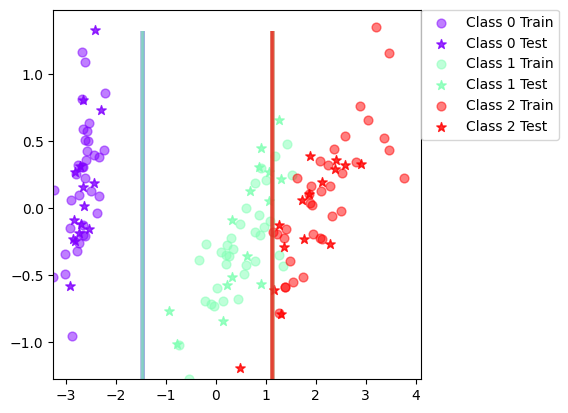

In [20]:
%matplotlib inline
plotBoundary(DecisionTreeClassifier(), dataset='iris',split=0.7)

/Users/lelle/KTH4/ml/bayesboost/labfuns.py:256: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xTr[trClIdx,0],xTr[trClIdx,1],marker='o',c=color,s=40,alpha=0.5, label="Class "+str(c)+" Train")
/Users/lelle/KTH4/ml/bayesboost/labfuns.py:257: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xTe[teClIdx,0],xTe[teClIdx,1],marker='*',c=color,s=50,alpha=0.8, label="Class "+str(c)+" Test")


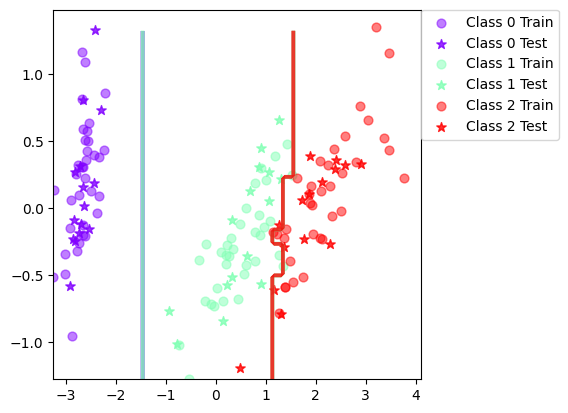

In [21]:
%matplotlib inline
plotBoundary(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

## Bonus: Visualize faces classified using boosted decision trees

Note that this part of the assignment is completely voluntary! First, let's check how a boosted decision tree classifier performs on the olivetti data. Note that we need to reduce the dimension a bit using PCA, as the original dimension of the image vectors is `64 x 64 = 4096` elements.

In [23]:
testClassifier(BayesClassifierW(), dataset='olivetti',split=0.7, dim=20)

Trial: 0 Accuracy 88.3
Trial: 10 Accuracy 90.8
Trial: 20 Accuracy 85
Trial: 30 Accuracy 89.2
Trial: 40 Accuracy 89.2
Trial: 50 Accuracy 84.2
Trial: 60 Accuracy 91.7
Trial: 70 Accuracy 82.5
Trial: 80 Accuracy 81.7
Trial: 90 Accuracy 86.7
Final mean classification accuracy  87.7 with standard deviation 3.03


In [24]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='olivetti',split=0.7, dim=20)

Trial: 0 Accuracy 74.2
Trial: 10 Accuracy 68.3
Trial: 20 Accuracy 74.2
Trial: 30 Accuracy 75.8
Trial: 40 Accuracy 71.7
Trial: 50 Accuracy 67.5
Trial: 60 Accuracy 75
Trial: 70 Accuracy 76.7
Trial: 80 Accuracy 72.5
Trial: 90 Accuracy 72.5
Final mean classification accuracy  70.5 with standard deviation 6.21


You should get an accuracy around 70%. If you wish, you can compare this with using pure decision trees or a boosted bayes classifier. Not too bad, now let's try and classify a face as belonging to one of 40 persons!

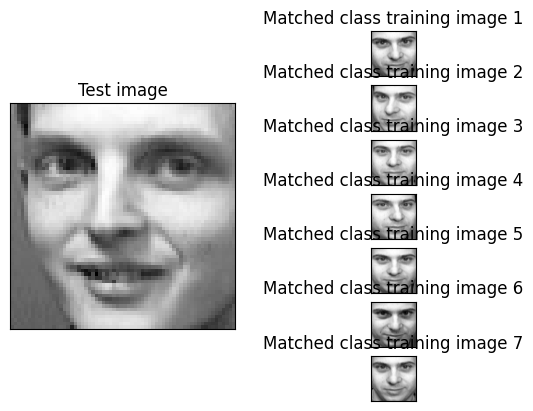

In [25]:
%matplotlib inline
X,y,pcadim = fetchDataset('olivetti') # fetch the olivetti data
xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,0.7) # split into training and testing
pca = decomposition.PCA(n_components=20) # use PCA to reduce the dimension to 20
pca.fit(xTr) # use training data to fit the transform
xTrpca = pca.transform(xTr) # apply on training data
xTepca = pca.transform(xTe) # apply on test data
# use our pre-defined decision tree classifier together with the implemented
# boosting to classify data points in the training data
classifier = BoostClassifier(DecisionTreeClassifier(), T=10).trainClassifier(xTrpca, yTr)
yPr = classifier.classify(xTepca)
# choose a test point to visualize
testind = random.randint(0, xTe.shape[0]-1)
# visualize the test point together with the training points used to train
# the class that the test point was classified to belong to
visualizeOlivettiVectors(xTr[yTr == yPr[testind],:], xTe[testind,:])